In [1]:
# This notebook is for writing a script that iteratively batches a dataset, applies HDBSCAN, pools the anomalies,
# then does it over again.

# Differences from batch_hdbscan.ipynb:
#
#  -  This notebook must keep track of non-anomalous clusters as well as anomalies,
#       and we must find a decent way to match them to each other across batches.
#
#  -  This notebook must get rid of the day-long process in retrieve_anomalous_hits.ipynb.
#       This will be done by assigning hits indices that are carried around with them as they
#       get batched and shuffled.
#
#  -  At the end, we should have:
#       (a) a list of anomalous hits, ideally no more than 10% of the initial dataset, which
#           can be passed through FindEvent for interesting results
#       (b) a list of RFI classes, which can be plotted in PDF form to demonstrate the efficacy
#           of the clustering

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm, mode
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
import shutil
import os
%matplotlib inline

In [113]:
def preprocess(data):

    freqs = data[:,0]
    drifts = data[:,1]
    snrs = data[:,2]
    skews = data[:,3]
    kurts = data[:,4]
    sarles = data[:,5]
    corrs = data[:,6]
    tbws = data[:,7]
    tskews = data[:,8]
    tstds = data[:,9]
    fstds = data[:,10]
    sigbws = data[:,11]

    normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=100000, 
                                   output_distribution='normal', subsample=100000)
    normal_drifts = normal_drifts.reshape(len(normal_drifts))

    data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                        #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                        np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                        (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                        (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                        (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                        sarles, 
                        corrs, 
                        (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                        (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                        (np.log10(tstds)-np.min(np.log10(tstds))),
                        (np.log10(fstds)-np.min(np.log10(fstds))),
                        sigbws/np.max(sigbws)
                        ])  ### PRE-PROCESSED FOR HDBSCAN

    data_arr_unscaled = np.array([freqs, 
                        drifts, 
                        snrs, 
                        skews, 
                        kurts, 
                        sarles, 
                        corrs, 
                        tbws*1e6, # units of Hz
                        tskews,
                        tstds,
                        fstds,
                        sigbws*1e6 # units of Hz
                        ])

    return np.transpose(data_arr), np.transpose(data_arr_unscaled)

def batch_hdbscan(batch_arr_scaled, nmincluster, nminsamples, eps):

    hdb = HDBSCAN(
        min_cluster_size=nmincluster, 
        min_samples=nminsamples, 
        cluster_selection_epsilon=eps, 
        #metric = 'haversine',
        leaf_size=40,
        n_jobs=10,
        cluster_selection_method='eom',
        store_centers='centroid')
    
    X = batch_arr_scaled
    hdb.fit(X)

    labels_list = hdb.labels_
    centroids = hdb.centroids_

    return labels_list, centroids

In [114]:
hit_params = np.load('/datax/scratch/benjb/C23_L_unique_param_array.npy', allow_pickle=True)
hit_dats = np.load('/datax/scratch/benjb/C23_L_unique_dat_list.npy', allow_pickle=True)[:,1]

for dat in np.unique(hit_dats):
    shutil.copy(dat, '/datax/scratch/benjb/C23_L_dats_iterative/')

In [115]:
dataset_sizes = [len(hit_dats)]
non_anom_centroids = [] # tracks idx and centroid for each non-anomalous hit

stg_params = np.load('/datax/scratch/benjb/C23_L_full_injected_params.npy', allow_pickle=True)

full_params = np.vstack((hit_params, stg_params)) # need to be preprocessed together for quantile transforms
full_params_scaled, full_params_unscaled = preprocess(full_params)

# separate injected hits again so they can be re-injected into each batch later
hit_params_scaled_0 = full_params_scaled[:-10]
print(f'Size hit_params_scaled = {len(hit_params_scaled_0)}')
hit_params_unscaled_0 = full_params_unscaled[:-10]
print(f'Size hit_params_unscaled = {len(hit_params_unscaled_0)}')
stg_params_scaled = full_params_scaled[-10:]
stg_params_unscaled = full_params_unscaled[-10:]

hit_idxs = np.arange(len(hit_dats))

round_idxs = np.copy(hit_idxs) # i.e. 'anomalous' idxs for the current round

hit_params_scaled = hit_params_scaled_0[round_idxs] # set this in advance so the while loop doesn't immediately break

round_counter = 0

while len(hit_params_scaled) > 0.1 * dataset_sizes[0]:

    round_counter += 1
    print(f'Commencing round {round_counter}!')

    n_batches = len(hit_dats) // 5000
    batch_size = len(hit_dats) // n_batches  # should be approx but probably not exactly 5k

    #round_idxs = hit_idxs[keep_idxs] # these are for tracking anom hits

    hit_params_scaled = hit_params_scaled_0[round_idxs]
    hit_params_unscaled = hit_params_unscaled_0[round_idxs]

    print(f'{len(hit_params_scaled)} hits in dataset ({100*len(hit_params_scaled)/dataset_sizes[0]}% of original).')
    dataset_sizes.append(len(hit_params_scaled))

    hit_batches_scaled = []
    hit_batches_unscaled = []
    dat_batches = []
    idx_batches = []

    # shuffle hits before batching
    idxs = np.arange(len(hit_params_scaled))
    np.random.shuffle(idxs) 
    hit_params_scaled_shuffled = hit_params_scaled[idxs]
    hit_params_unscaled_shuffled = hit_params_unscaled[idxs]
    hit_dats_shuffled = hit_dats[idxs]
    round_idxs_shuffled = round_idxs[idxs]

    print('Batching ...')

    # do the batching
    for i in range(n_batches):

        if i != n_batches-1:
            batch_scaled = hit_params_scaled_shuffled[i*batch_size:(i+1)*batch_size]
            batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:(i+1)*batch_size]
            hit_dats_batch = hit_dats_shuffled[i*batch_size:(i+1)*batch_size]
            round_idxs_batch = round_idxs_shuffled[i*batch_size:(i+1)*batch_size]
        else:
            batch_scaled = hit_params_scaled_shuffled[i*batch_size:] # catch the last few entries in the final batch
            batch_unscaled = hit_params_unscaled_shuffled[i*batch_size:]
            hit_dats_batch = hit_dats_shuffled[i*batch_size:]
            round_idxs_batch = round_idxs_shuffled[i*batch_size:]

        hit_batches_scaled.append(batch_scaled)
        hit_batches_unscaled.append(batch_unscaled)
        dat_batches.append(hit_dats_batch)
        idx_batches.append(round_idxs_batch)

    print('Running HDBSCAN on all batches ...')

    # do the HDBSCANning
    nmincluster = 4
    nminsamples = 2
    eps = 0.17

    dat_list_for_hit_deletion = np.empty((0, 2))
    round_idxs_new = []

    for i in range(len(hit_batches_scaled)):
        #print('-----')
        bbb_scaled = np.vstack((hit_batches_scaled[i], stg_params_scaled))
        labels_list, centroids = batch_hdbscan(bbb_scaled, nmincluster, nminsamples, eps)
        dat_freq_obj = np.transpose(np.array([hit_batches_unscaled[i][:,0], dat_batches[i]], dtype='object'))
        non_anom_labels = np.array(list(
            set(np.unique(labels_list))-set(np.unique(np.concatenate((labels_list[-10:], [-1]))))
            ))
        mask = np.isin(labels_list[:-10], non_anom_labels)
        dat_freq_obj = dat_freq_obj[mask]
        #centroids = centroids[non_anom_labels]

        # track non-anomalous hits for later superclustering 
        truncated_labels_list = labels_list[:-10]
        #print(f'Truncated labels list len {len(truncated_labels_list)}')
        non_anom_labels_list = truncated_labels_list[mask]
        #print(f'Non-anom labels list len {len(non_anom_labels_list)}')
        #print(f'Non-anom labels list max {np.max(non_anom_labels_list)}')
        #print(f'Centroids len {len(centroids)}')
        centroids_list = centroids[non_anom_labels_list]
        #print(f'Centroids list len {len(centroids_list)}')
        idx_batch = idx_batches[i]
        non_anom_idxs_in_batch = idx_batch[mask]
        #print(f'Non-anom idxs in batch len {len(non_anom_idxs_in_batch)}')
        for j in range(len(non_anom_idxs_in_batch)):
            # need to be careful about indexing here
            # [0] should be from non_anom_idxs_in_batch, not idx_batch
            non_anom_centroids.append([non_anom_idxs_in_batch[j], centroids_list[j]])

        # non-anomalous hits to be deleted
        dat_list_for_hit_deletion = np.concatenate((dat_list_for_hit_deletion, dat_freq_obj))

        # for updating round_idxs
        keep_idxs = idx_batch[~mask] # recall that round_idxs gives the anomalous idxs for the current round
        for ii in keep_idxs:
            round_idxs_new.append(ii)

    # after running all batches, delete non-anomalous hits
    for i in range(len(dat_list_for_hit_deletion)):
        freq = dat_list_for_hit_deletion[i][0]
        dat_path = '/datax/scratch/benjb/C23_L_dats_iterative/'+os.path.basename(dat_list_for_hit_deletion[i][1])
        if i%20000 == 0:
            print(f'{i}: Removing hit at frequency {freq} from {dat_path}')

        bytes_available = psutil.virtual_memory()[1]
        if bytes_available <= 32e9:
            print(f'Memory dangerously low: {bytes_available} bytes remaining. Breaking ...')
            break

        lines = []
        for line in open(dat_path):
            if not str(freq) in line:
                lines.append(line)

        with open(dat_path, 'w') as file:
            file.writelines(lines)
            file.close() # confirm whether this is truly overwriting the .dat files
                         # perhaps with a hit count check at the beginning of the while loop

    # update round_idxs
    round_idxs = np.copy(round_idxs_new)
        

Size hit_params_scaled = 1917903
Size hit_params_unscaled = 1917903
Commencing round 1!
1917903 hits in dataset (100.0% of original).
Batching ...
Running HDBSCAN on all batches ...
0: Removing hit at frequency 1179.608038 from /datax/scratch/benjb/C23_L_dats_iterative/blc05_guppi_59884_39889_HIP61135_0031.rawspec.0000.dat
20000: Removing hit at frequency 1618.267279 from /datax/scratch/benjb/C23_L_dats_iterative/blc03_guppi_59405_56904_NGC1407_0066.rawspec.0000.dat
40000: Removing hit at frequency 1574.297844 from /datax/scratch/benjb/C23_L_dats_iterative/blc33_guppi_59860_22014_Maffei1_0026.rawspec.0000.dat
60000: Removing hit at frequency 1575.518654 from /datax/scratch/benjb/C23_L_dats_iterative/blc03_guppi_59426_77731_HIP59400_0013.rawspec.0000.dat
80000: Removing hit at frequency 1599.44487 from /datax/scratch/benjb/C23_L_dats_iterative/blc73_guppi_58832_20115_And_XVI_0069.gpuspec.0000.dat
100000: Removing hit at frequency 1383.598018 from /datax/scratch/benjb/C23_L_dats_iterativ

In [116]:
print(len(non_anom_centroids))

1782224


In [117]:
cci = np.array([c[0] for c in non_anom_centroids])

In [118]:
ccc = np.array([c[1] for c in non_anom_centroids])
print(ccc.shape)

(1782224, 12)


In [127]:
np.save('/datax/scratch/benjb/C23_L_non_anom_centroid_idxs.npy', cci)
np.save('/datax/scratch/benjb/C23_L_non_anom_centroids.npy', ccc)

In [ ]:
### PICK BACK UP HERE 08/29/24

In [126]:
print(len(np.unique(cci)))

1782224


In [128]:
print(len(ccc)+135679)

1917903


In [120]:
print(len(round_idxs))

135679


In [121]:
dat_sizes = np.array(dataset_sizes[1:])
dat_sizes = np.concatenate((dat_sizes, [135679]))
print(dat_sizes)

[1917903 1095967  687740  499862  354721  276220  220727  182218  135679]


In [122]:
yyyy = 100*dat_sizes/dat_sizes[0]
print(yyyy)

[100.          57.14402657  35.85895637  26.06294479  18.49525237
  14.40218822  11.50876765   9.50089759   7.07434109]


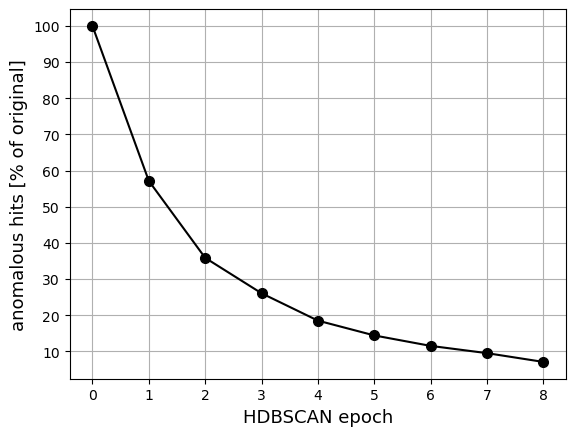

In [124]:
xxx = np.arange(9)
#yyy = 100*dat_sizes/dat_sizes[0]
plt.plot(xxx, yyyy, 'o-', color='k', markersize=7, label='empirical')
#plt.plot(np.linspace(0,8,100), 10**p(np.log10(np.linspace(1,9,100))), color='r', label='power law fit')
plt.grid()
plt.yticks([10,20,30,40,50,60,70,80,90,100])
plt.xlabel('HDBSCAN epoch', size=13)
plt.ylabel(r'anomalous hits [% of original]', size=13)
#plt.legend()
#plt.ylim(2,108)
plt.savefig('/datax/scratch/benjb/C23_L_hit_reduction_by_epoch_2.pdf', bbox_inches='tight')
plt.show()

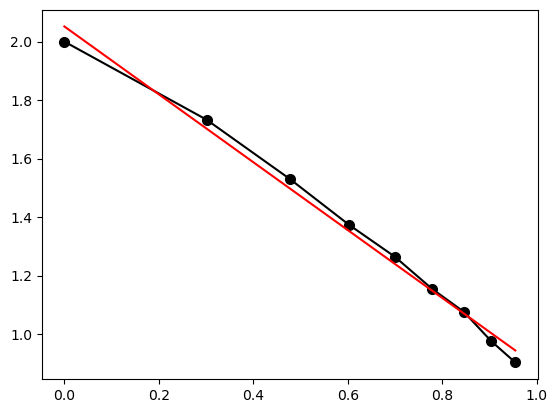

In [72]:
plt.plot(np.log10(xxx+1), np.log10(yyy), 'o-', color='k', markersize=7)
z = np.polyfit(np.log10(xxx+1), np.log10(yyy), 1)
p = np.poly1d(z)
plt.plot(np.log10(xxx+1), p(np.log10(xxx+1)), color='r')
plt.show()

In [73]:
print(z)

[-1.16070807  2.05170783]


In [97]:
print(yyy)

[100.          54.0537243   33.90604217  23.65458524  18.4049454
  14.27726011  11.92218793   9.46695427   7.99732833]


In [74]:
a = np.log10(2.05170783)
b = -1.16070807

In [125]:
reds = []

for i in range(len(xxx)-1):
    curr = yyyy[i]
    foll = yyyy[i+1]
    #print(curr, foll)
    reduction = (curr-foll) / curr
    print(reduction)
    reds.append(reduction)

0.4285597342514194
0.3724811057267235
0.273181725652136
0.2903621399506264
0.22130350331669116
0.20090145536166826
0.17446438360508676
0.2554028690908692


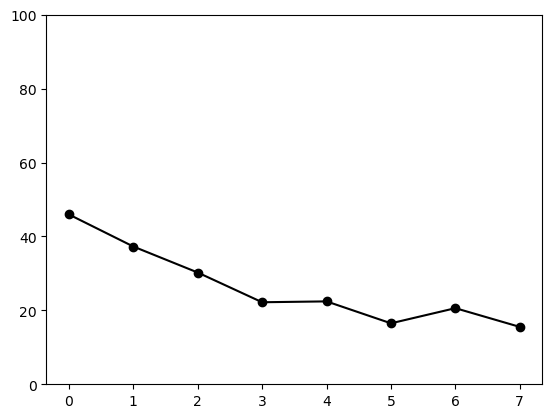

In [96]:
plt.plot(np.array(reds)*100, 'o-', color='k')
plt.ylim(0,100)
plt.show()

In [89]:
print((100-54)/100)
print((54-34)/54)

0.46
0.37037037037037035


In [63]:
print(xxx)
print(yyy)

[0 1 2 3 4 5 6 7 8]
[100.          54.0537243   33.90604217  23.65458524  18.4049454
  14.27726011  11.92218793   9.46695427   7.99732833]


In [49]:
print(dat_sizes/dat_sizes[0])
print(np.array([0.58**x for x in np.arange(8)]))

[1.         0.54053724 0.33906042 0.23654585 0.18404945 0.1427726
 0.11922188 0.09466954]
[1.         0.58       0.3364     0.195112   0.11316496 0.06563568
 0.03806869 0.02207984]


In [10]:
a = [2, 3, 5, 7, 11]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

mask = np.isin(b, a)
print(mask)
print(~mask)

[False  True  True False  True False  True False False False  True False]
[ True False False  True False  True False  True  True  True False  True]


In [13]:
print(np.array(b)[mask])

[ 1  4  6  8  9 10 12]
